<a href="https://colab.research.google.com/github/likith18/FAST-K_means/blob/main/FAST_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sentence-transformers scikit-learn matplotlib tqdm umap-learn seaborn

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


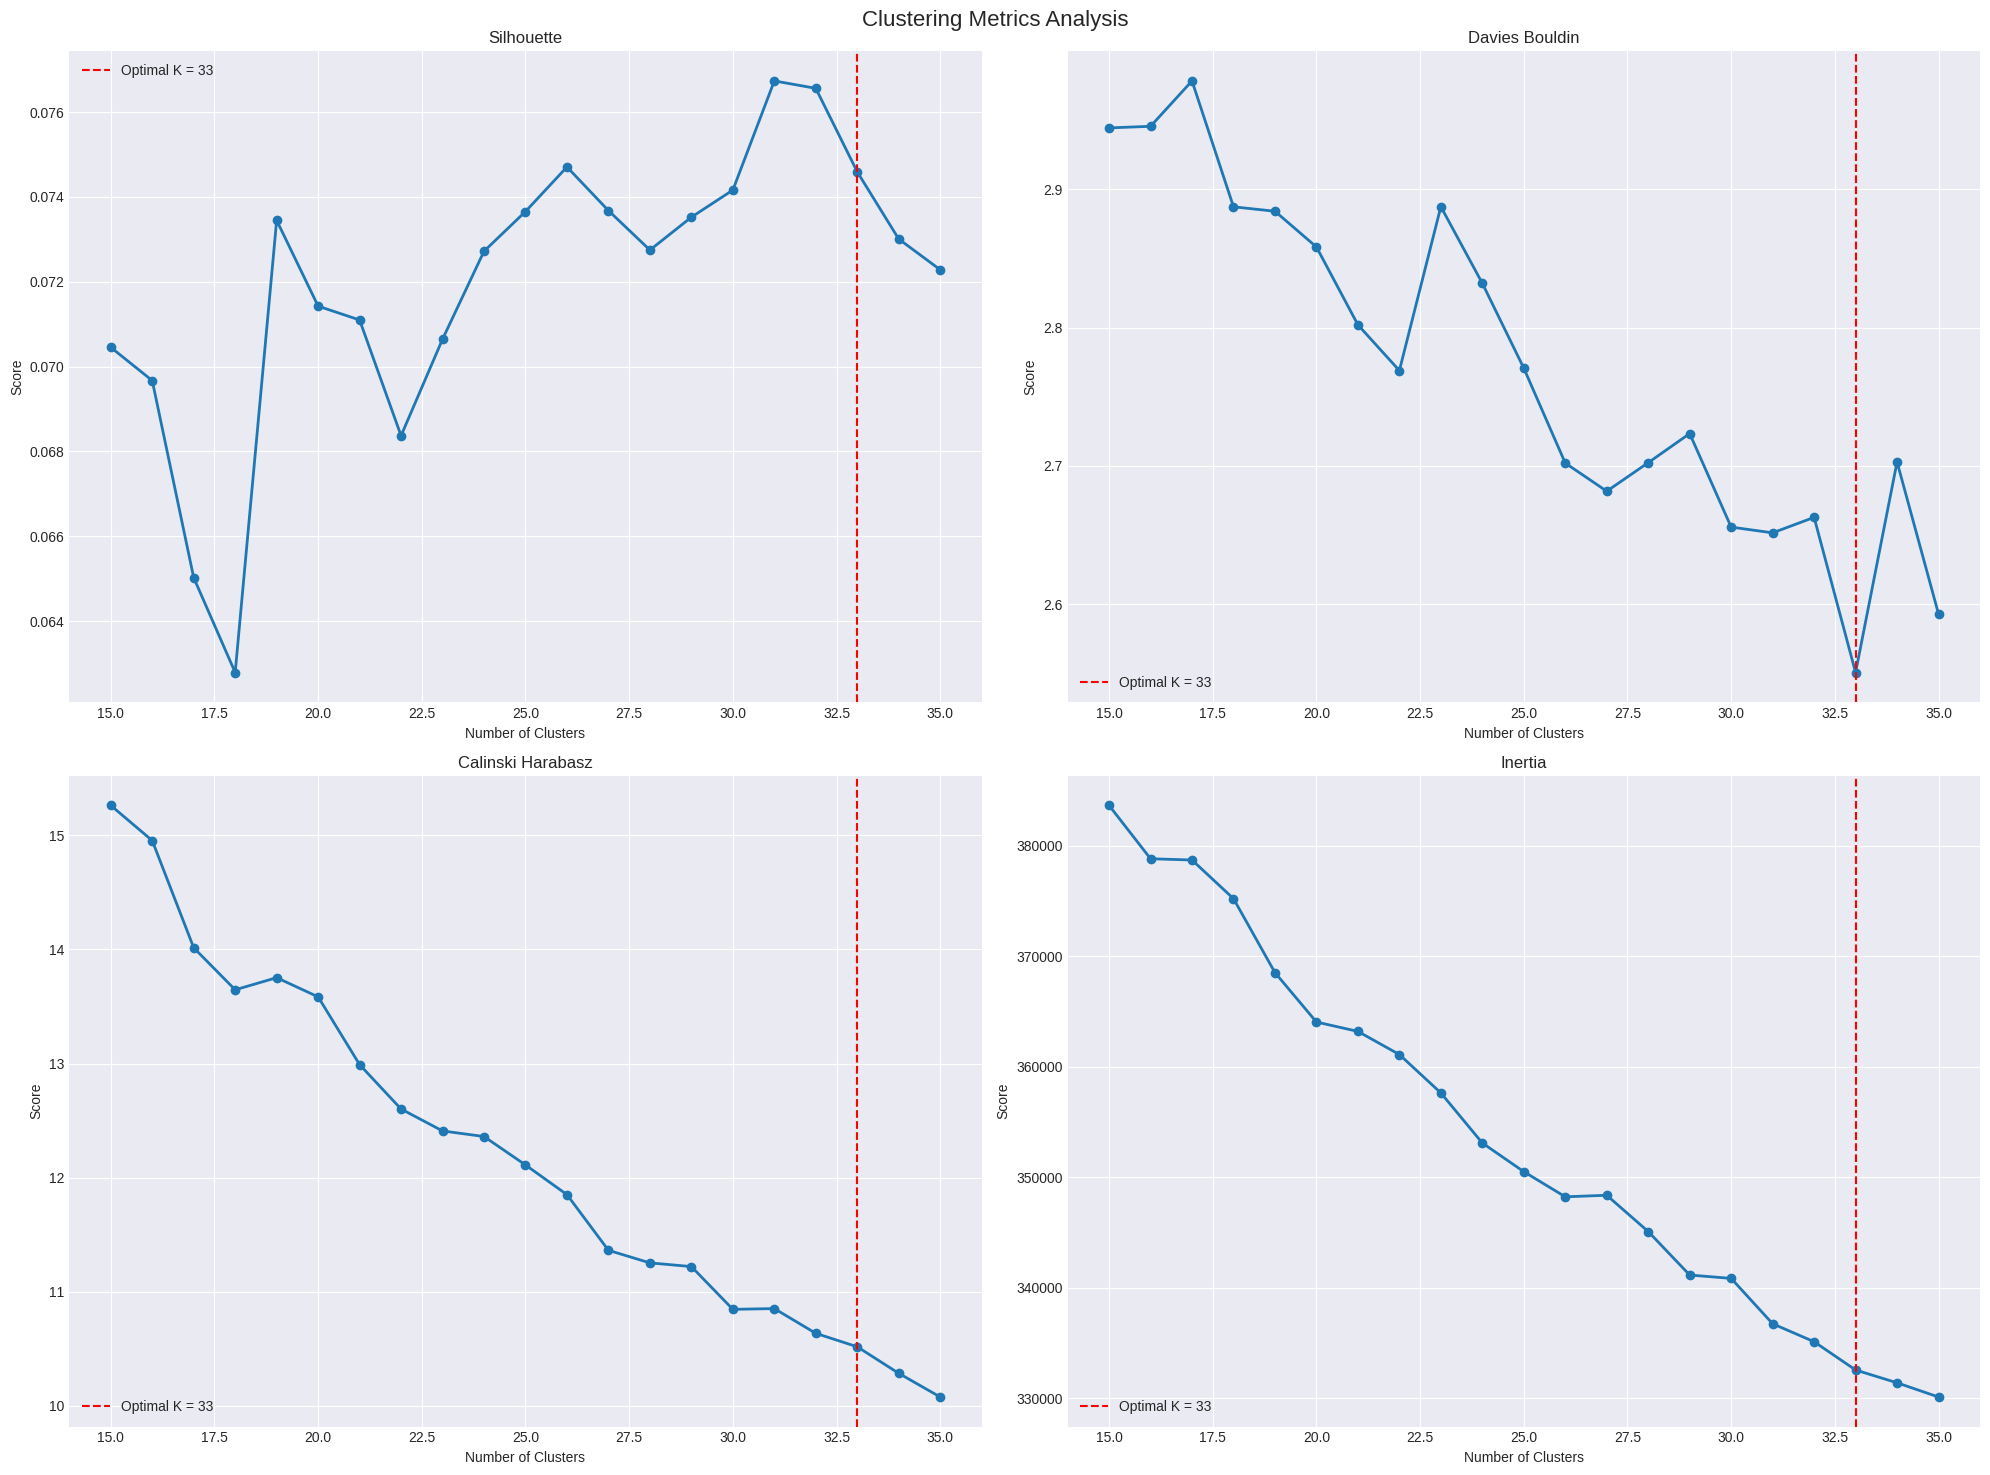

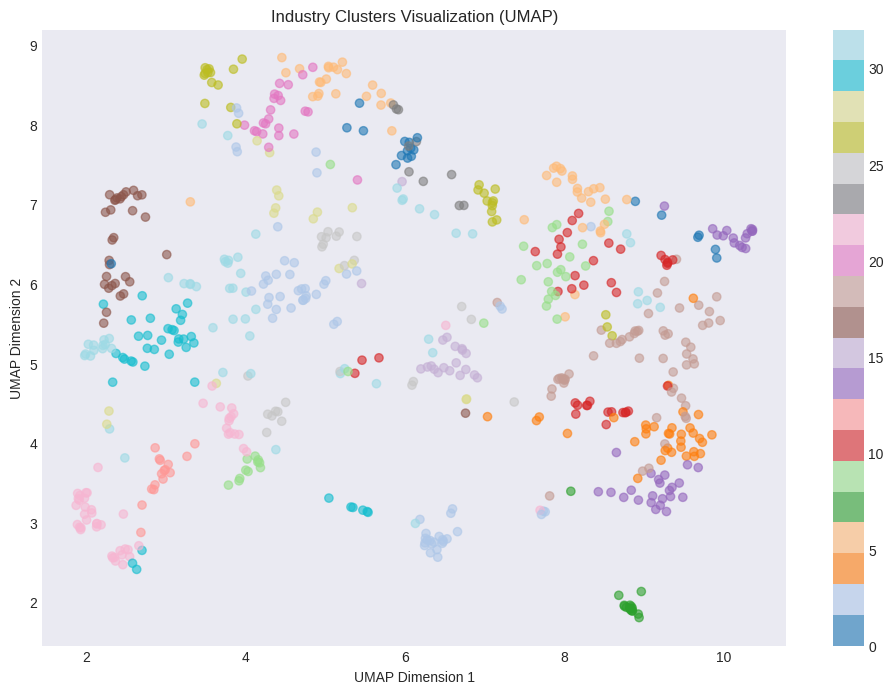

In [ ]:
import json
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass
from pathlib import Path
import logging
import torch
from torch.utils.data import DataLoader
import umap
from sklearn.manifold import TSNE

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

@dataclass
class ClusteringConfig:
    """Configuration for clustering parameters."""
    min_clusters: int = 15
    max_clusters: int = 35
    random_state: int = 42
    model_name: str = 'all-mpnet-base-v2'
    batch_size: int = 32
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

class IndustryClusteringModel:
    """Enhanced industry clustering model with improved features and error handling."""

    def __init__(self, config: ClusteringConfig):
        self.config = config
        self.model = None
        self.kmeans = None
        self.centroids = None
        self.cluster_mapping = {}
        self.embeddings = None
        self.scaler = StandardScaler()

    def load_data(self, json_file: str) -> pd.DataFrame:
        """Load and preprocess industry data with error handling."""
        try:
            with Path(json_file).open('r') as f:
                industry_data = json.load(f)

            if not industry_data:
                logger.warning("Empty JSON file. Initializing with empty dictionary.")
                return pd.DataFrame()

            combined_industries = []
            for main_industry, sub_industries in industry_data.items():
                combined_industries.append({
                    'industry': main_industry,
                    'type': 'main',
                    'main_industry': main_industry
                })
                for sub_industry in sub_industries:
                    combined_industries.append({
                        'industry': sub_industry,
                        'type': 'sub',
                        'main_industry': main_industry
                    })

            return pd.DataFrame(combined_industries)

        except (json.JSONDecodeError, FileNotFoundError) as e:
            logger.error(f"Error loading data: {str(e)}")
            raise

    def generate_embeddings(self, texts) -> np.ndarray:
        """Generate embeddings with batched processing and progress tracking."""
        if self.model is None:
            self.model = SentenceTransformer(self.config.model_name)
            self.model = self.model.to(self.config.device)


        if isinstance(texts,str):
          texts = [texts]

        embeddings_list = []
        dataloader = DataLoader(texts, batch_size=self.config.batch_size)

        with torch.no_grad():
            for batch in dataloader:
                batch_embeddings = self.model.encode(
                    batch,
                    show_progress_bar=False,
                    convert_to_tensor=True,
                    device=self.config.device
                )
                embeddings_list.append(batch_embeddings.cpu().numpy())

        return np.vstack(embeddings_list)

    def find_optimal_clusters(self, embeddings: np.ndarray) -> Tuple[int, dict]:
        """Find optimal number of clusters using multiple metrics."""
        metrics = {
            'silhouette': [],
            'davies_bouldin': [],
            'calinski_harabasz': [],
            'inertia': []
        }

        range_n_clusters = range(self.config.min_clusters, self.config.max_clusters + 1)

        for n_clusters in range_n_clusters:
            kmeans = KMeans(
                n_clusters=n_clusters,
                random_state=self.config.random_state,
                n_init=10
            )
            labels = kmeans.fit_predict(embeddings)

            metrics['silhouette'].append(silhouette_score(embeddings, labels))
            metrics['davies_bouldin'].append(davies_bouldin_score(embeddings, labels))
            metrics['calinski_harabasz'].append(calinski_harabasz_score(embeddings, labels))
            metrics['inertia'].append(kmeans.inertia_)

        # Normalize metrics for weighted voting
        normalized_metrics = {}
        for metric_name, values in metrics.items():
            if metric_name in ['davies_bouldin', 'inertia']:
                # Lower is better for these metrics
                normalized_metrics[metric_name] = 1 - (values - np.min(values)) / (np.max(values) - np.min(values))
            else:
                # Higher is better for these metrics
                normalized_metrics[metric_name] = (values - np.min(values)) / (np.max(values) - np.min(values))

        # Weighted voting for optimal clusters
        weights = {
            'silhouette': 0.4,
            'davies_bouldin': 0.3,
            'calinski_harabasz': 0.2,
            'inertia': 0.1
        }

        combined_scores = np.zeros(len(range_n_clusters))
        for metric_name, weight in weights.items():
            combined_scores += normalized_metrics[metric_name] * weight

        optimal_k = range_n_clusters[np.argmax(combined_scores)]

        return optimal_k, metrics

    def visualize_metrics(self, metrics: dict, optimal_k: int):
        """Visualize clustering metrics with enhanced plots."""
        plt.style.use('seaborn-v0_8-dark')
        fig, axes = plt.subplots(2, 2, figsize=(20, 15))
        fig.suptitle('Clustering Metrics Analysis', fontsize=16)

        range_n_clusters = range(self.config.min_clusters, self.config.max_clusters + 1)

        # Plot each metric
        for (metric_name, values), ax in zip(metrics.items(), axes.ravel()):
            ax.plot(range_n_clusters, values, marker='o', linewidth=2)
            ax.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal K = {optimal_k}')
            ax.set_title(f'{metric_name.replace("_", " ").title()}')
            ax.set_xlabel('Number of Clusters')
            ax.set_ylabel('Score')
            ax.legend()
            ax.grid(True)

        plt.tight_layout()
        return fig

    def visualize_clusters(self, embeddings: np.ndarray, labels: np.ndarray):
        """Visualize clusters using dimensionality reduction."""
        # UMAP for visualization
        umap_reducer = umap.UMAP(random_state=self.config.random_state)
        umap_embeddings = umap_reducer.fit_transform(embeddings)

        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1],
                            c=labels, cmap='tab20', alpha=0.6)
        plt.colorbar(scatter)
        plt.title('Industry Clusters Visualization (UMAP)')
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('UMAP Dimension 2')
        return plt.gcf()

    def fit(self, df: pd.DataFrame):
        """Fit the clustering model with enhanced error handling."""
        try:
            # Generate and normalize embeddings
            self.embeddings = self.generate_embeddings(df['industry'].tolist())
            self.embeddings = self.scaler.fit_transform(self.embeddings)

            # Find optimal number of clusters
            optimal_k, metrics = self.find_optimal_clusters(self.embeddings)
            logger.info(f"Optimal number of clusters: {optimal_k}")

            # Perform final clustering
            self.kmeans = KMeans(
                n_clusters=optimal_k,
                random_state=self.config.random_state,
                n_init=10
            )
            df['cluster'] = self.kmeans.fit_predict(self.embeddings)
            self.centroids = self.kmeans.cluster_centers_

            # Create cluster mapping
            for cluster in range(optimal_k):
                cluster_industries = df[df['cluster'] == cluster]
                main_industries = cluster_industries[
                    cluster_industries['type'] == 'main'
                ]['industry'].tolist()

                if not main_industries:
                    main_industries = [
                        cluster_industries['main_industry'].mode().iloc[0]
                    ]

                self.cluster_mapping[cluster] = {
                    'main_industries': main_industries,
                    'industries': cluster_industries['industry'].tolist(),
                    'size': len(cluster_industries)
                }

            return metrics, optimal_k

        except Exception as e:
            logger.error(f"Error in fitting model: {str(e)}")
            raise

    def predict(self, new_industry: str) -> Dict:
        """Predict cluster for new industry with enhanced similarity metrics."""
        if self.centroids is None:
            raise ValueError("Model not fitted. Run fit() first.")

        try:
            # Generate embedding for new industry
            new_embedding = self.generate_embeddings(new_industry)
            new_embedding = self.scaler.transform(new_embedding)

            # new_embedding = new_embedding.flatten()

            # Find closest cluster
            distances = np.linalg.norm(self.centroids - new_embedding, axis=1)
            closest_cluster = np.argmin(distances)

            # Calculate similarities with all industries
            similarities = 1 - (np.linalg.norm(self.embeddings - new_embedding, axis=1) / np.sqrt(2))

            # Get top similar industries
            top_k = 5
            top_indices = np.argsort(similarities)[-top_k:][::-1]

            similar_industries = [
                {
                    'industry': df.iloc[idx]['industry'],
                    'main_industry': df.iloc[idx]['main_industry'],
                    'similarity': float(similarities[idx]),
                    'cluster': int(df.iloc[idx]['cluster'])
                }
                for idx in top_indices
            ]

            return {
                'input_industry': new_industry,
                'predicted_cluster': int(closest_cluster),
                'cluster_info': self.cluster_mapping[closest_cluster],
                'similar_industries': similar_industries,
                'confidence_score': float(1 - min(distances) / np.mean(distances))
            }

        except Exception as e:
            logger.error(f"Error in prediction: {str(e)}")
            raise

def main():
    """Main execution function with improved error handling and logging."""
    try:
        # Initialize configuration
        config = ClusteringConfig()

        # Initialize model
        model = IndustryClusteringModel(config)

        # Load and preprocess data
        df = model.load_data('new_structured_data.json')
        if df.empty:
            logger.error("No data loaded. Exiting.")
            return

        # Fit model and get metrics
        metrics, optimal_k = model.fit(df)

        # Visualize results
        model.visualize_metrics(metrics, optimal_k)
        model.visualize_clusters(model.embeddings, df['cluster'])

        # Save results
        results = {
            'clusters': model.cluster_mapping,
            'industry_assignments': df.to_dict(orient='records')
        }

        with open('improved_linkedin_industry_clusters.json', 'w') as f:
            json.dump(results, f, indent=2)

        logger.info("Model training and evaluation completed successfully.")

    except Exception as e:
        logger.error(f"Error in main execution: {str(e)}")
        raise

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd

# Function to get industry recommendations for multiple inputs
def get_industry_recommendations(input_industries):

    prediction_dict = {}

    x = 1
    for input_industry in input_industries:

        # print(type(input_industry))
        # Run prediction for each industry
        prediction_result = model.predict(input_industry)

        # Determine the final main industry based on similar industries and main industries
        cluster_info = prediction_result['cluster_info']
        similar_industries_df = pd.DataFrame(prediction_result['similar_industries'])
        all_main_industries = cluster_info['main_industries'] + similar_industries_df['main_industry'].tolist()
        final_main_industry = pd.Series(all_main_industries).mode().iloc[0]
        count = x
        x += 1
        print(f"{count}.")
        # print("Input Industry:", input_industry, "\n", "Main Industry:", final_main_industry, "\n\n")

        # Store the result in the dictionary
        prediction_dict[input_industry] = final_main_industry

    return prediction_dict

# List of input industries
input_industries = [
    "Health Tech Innovator",
    "Retail Merchandising Specialist",
    "Brand Strategy Consultant",
    "Internet of Things (IoT) Engineer",
    "Corporate Training Facilitator",
]

# input_industries = [
#     "fishery"
# ]

# Get recommendations for multiple industries
industry_recommendations = get_industry_recommendations(input_industries)

# Print the recommendations
print(industry_recommendations)

1.
Input Industry: Health Tech Innovator 
 Main Industry: Healthcare 


2.
Input Industry: Retail Merchandising Specialist 
 Main Industry: Retail 


3.
Input Industry: Brand Strategy Consultant 
 Main Industry: Corporate Services 


4.
Input Industry: Internet of Things (IoT) Engineer 
 Main Industry: Software and IT Services 


5.
Input Industry: Corporate Training Facilitator 
 Main Industry: Corporate Services 


{'Health Tech Innovator': 'Healthcare', 'Retail Merchandising Specialist': 'Retail', 'Brand Strategy Consultant': 'Corporate Services', 'Internet of Things (IoT) Engineer': 'Software and IT Services', 'Corporate Training Facilitator': 'Corporate Services'}


In [ ]:
# Load the JSON file and initialize the model
config = ClusteringConfig()
model = IndustryClusteringModel(config)
df = model.load_data('new_structured_data.json')

# Fit the model with the existing data
metrics, optimal_k = model.fit(df)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# O/P in Table Data format for single Value

import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import pandas as pd

# Initialize input widgets with styling
industry_input = widgets.Text(
    description="Industry Name:",
    placeholder="Enter an industry name...",
    layout=widgets.Layout(width='300px')
)

predict_button = widgets.Button(
    description="Predict",
    button_style="success",
    layout=widgets.Layout(width='100px')
)

# Container to align the input field and the button side by side
input_container = widgets.HBox([industry_input, predict_button])

# Output area for displaying the results
output_area = widgets.Output()

def on_predict_button_clicked(b):
    with output_area:
        clear_output()  # Clear previous output

        # Retrieve the input industry name
        new_industry = industry_input.value.strip()
        if not new_industry:
            print("Please enter a valid industry name.")
            return

        # Run prediction
        prediction_result = model.predict(new_industry)

        # Prepare main information DataFrame
        main_info_df = pd.DataFrame({
            "Input Industry": [prediction_result['input_industry']],
            "Predicted Cluster": [prediction_result['predicted_cluster']],
            "Confidence Score": [prediction_result['confidence_score']]
        })

        # Prepare cluster info DataFrame
        cluster_info = prediction_result['cluster_info']
        cluster_info_df = pd.DataFrame({
            "Cluster ID": [prediction_result['predicted_cluster']],
            "Main Industries": [", ".join(cluster_info['main_industries'])],
            "Total Industries": [len(cluster_info['industries'])],
            "Cluster Size": [cluster_info['size']]
        })

        # Prepare similar industries DataFrame
        similar_industries_df = pd.DataFrame(prediction_result['similar_industries'])

        # Determine the final main industry based on similar industries and main industries
        all_main_industries = cluster_info['main_industries'] + similar_industries_df['main_industry'].tolist()
        final_main_industry = pd.Series(all_main_industries).mode().iloc[0]

        # Prepare the final main industry recommendation table
        final_main_industry_df = pd.DataFrame({
            "Given Industry": [new_industry],
            "Predicted Industry": [final_main_industry]
        })

        # Display results with styling
        # display(HTML("<h4>Main Prediction Info:</h4>"))
        # display(main_info_df.style.set_table_styles([{'selector': 'th', 'props': [('background-color', '#f7f7f9')]}]))

        # display(HTML("<h4>Cluster Information:</h4>"))
        # display(cluster_info_df.style.set_table_styles([{'selector': 'th', 'props': [('background-color', '#f7f7f9')]}]))

        display(HTML("<h4>Top Similar Industries:</h4>"))
        display(similar_industries_df.style.set_table_styles(
            [{'selector': 'th', 'props': [('background-color', '#f7f7f9'), ('color', 'black')]}]
        ))

        display(HTML("<h4>Final Main Industry Recommendation:</h4>"))
        display(final_main_industry_df.style.set_table_styles(
            [{'selector': 'th', 'props': [('background-color', '#f7f7f9'), ('color', 'black')]}]
        ))


# Set up the button click event
predict_button.on_click(on_predict_button_clicked)

# Display the input container and output UI
display(input_container, output_area)


Output()

In [ ]:
# O/P in Table Data format for multi value

import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import pandas as pd

# Initialize input widgets with styling
industry_input = widgets.Textarea(
    description="Industry Names:",
    placeholder="Enter industry names, one per line...",
    layout=widgets.Layout(width='300px', height='150px')
)

predict_button = widgets.Button(
    description="Predict",
    button_style="success",
    layout=widgets.Layout(width='100px')
)

# Container to align the input field and the button side by side
input_container = widgets.HBox([industry_input, predict_button])

# Output area for displaying the results
output_area = widgets.Output()

def on_predict_button_clicked(b):
    with output_area:
        clear_output()  # Clear previous output

        # Retrieve the input industry names
        industries = industry_input.value.strip().splitlines()
        industries = [industry.strip() for industry in industries if industry.strip()]  # Clean up empty entries
        if not industries:
            print("Please enter valid industry names.")
            return

        # Initialize lists to store results
        main_info_list = []
        cluster_info_list = []
        similar_industries_list = []
        final_main_industries = []

        for new_industry in industries:
            # Run prediction for each industry
            prediction_result = model.predict(new_industry)

            # Prepare main information DataFrame
            main_info_list.append({
                "Input Industry": prediction_result['input_industry'],
                "Predicted Cluster": prediction_result['predicted_cluster'],
                "Confidence Score": prediction_result['confidence_score']
            })

            # Prepare cluster info
            cluster_info = prediction_result['cluster_info']
            cluster_info_list.append({
                "Cluster ID": prediction_result['predicted_cluster'],
                "Main Industries": ", ".join(cluster_info['main_industries']),
                "Total Industries": len(cluster_info['industries']),
                "Cluster Size": cluster_info['size']
            })

            # Prepare similar industries DataFrame
            similar_industries_df = pd.DataFrame(prediction_result['similar_industries'])
            similar_industries_list.append(similar_industries_df)

            # Determine the final main industry based on similar industries and main industries
            all_main_industries = cluster_info['main_industries'] + similar_industries_df['main_industry'].tolist()
            final_main_industry = pd.Series(all_main_industries).mode().iloc[0]
            final_main_industries.append(final_main_industry)

        # Create DataFrames from the collected results
        main_info_df = pd.DataFrame(main_info_list)
        cluster_info_df = pd.DataFrame(cluster_info_list)
        final_main_industry_df = pd.DataFrame({
            "Given Industry": industries,
            "Predicted Industry": final_main_industries
        })

        # Display results with styling
        display(HTML("<h4>Main Prediction Info:</h4>"))
        display(main_info_df.style.set_table_styles(
            [{'selector': 'th', 'props': [('background-color', '#f7f7f9'), ('color', 'black')]}]
        ))

        # display(HTML("<h4>Cluster Information:</h4>"))
        # display(cluster_info_df.style.set_table_styles(
        #     [{'selector': 'th', 'props': [('background-color', '#f7f7f9'), ('color', 'black')]}]
        # ))

        display(HTML("<h4>Top Similar Industries:</h4>"))
        for idx, similar_df in enumerate(similar_industries_list):
            display(HTML(f"<strong>Similar Industries for {industries[idx]}:</strong>"))
            display(similar_df.style.set_table_styles(
                [{'selector': 'th', 'props': [('background-color', '#f7f7f9'), ('color', 'black')]}]
            ))

        display(HTML("<h4>Final Main Industry Recommendation:</h4>"))
        display(final_main_industry_df.style.set_table_styles(
            [{'selector': 'th', 'props': [('background-color', '#f7f7f9'), ('color', 'black')]}]
        ))

# Set up the button click event
predict_button.on_click(on_predict_button_clicked)

# Display the input container and output UI
display(input_container, output_area)


Output()